In [1]:
import os
import json
from web3 import Web3, HTTPProvider


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import datetime

In [2]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [3]:
pool_addr = "0xB576491F1E6e5E62f1d8F26062Ee822B40B0E0d4"
lp_token_addr = "0x3A283D9c08E8b55966afb64C515f5143cf907611"
tricrypto_addr = "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46"

In [4]:
admin_2 = "0xA464e6DCda8AC41e03616F95f4BC98a13b8922Dc"
admin = "0xeCb456EA5365865EbAb8a2661B0c503410e9B347"

In [5]:
pool_addr.lower()

'0xb576491f1e6e5e62f1d8f26062ee822b40b0e0d4'

In [11]:
with open("./cvxeth.json", 'r') as f:
    abi = json.load(f)
cvxeth = web3.eth.contract(address=pool_addr, abi=abi)

with open("../tricrypto/tricrypto2.json", 'r') as f:
    abi = json.load(f)
tricrypto2 = web3.eth.contract(address=tricrypto_addr, abi=abi)

In [7]:
start_block = 13783426
current_block = web3.eth.get_block_number()

In [8]:
datetime.datetime.fromtimestamp(web3.eth.getBlock(13685675)['timestamp'])

datetime.datetime(2021, 11, 25, 21, 50, 4)

In [12]:
transfer_filter = cvxeth.events.ClaimAdminFee.createFilter(
    fromBlock=start_block,
    toBlock=current_block
)
all_transfers = transfer_filter.get_all_entries()

In [13]:
len(all_transfers)

1285

In [14]:
fees_for_range = []
claimed_lp_tokens = 0
for transfer in all_transfers:

    value = transfer['args']['tokens']
    block = transfer['blockNumber']
    tx_hash = transfer['transactionHash'].hex()
    claimed_lp_tokens = value * 1e-18
    lp_token_price = cvxeth.functions.lp_price().call(block_identifier=block) * 1e-18
    eth_price = tricrypto2.functions.price_oracle(1).call(block_identifier=block) * 1e-18
    timestamp = datetime.datetime.fromtimestamp(web3.eth.getBlock(block)['timestamp'])

    dict_fees = {
        'block': block,
        'timestamp': timestamp,
        'lp_tokens': claimed_lp_tokens,
        'lp_token_price': lp_token_price,
        'eth_price': eth_price,
        'total_claimed_eth': claimed_lp_tokens * lp_token_price,
        'total_claimed_usd': claimed_lp_tokens * lp_token_price * eth_price,
        'tx_hash': tx_hash
    }
    fees_for_range.append(dict_fees)

df_fees = pd.DataFrame(fees_for_range)
df_fees

,block,timestamp,lp_tokens,lp_token_price,eth_price,total_claimed_eth,total_claimed_usd,tx_hash
0,13790373,2021-12-12 13:42:26,0.182717,0.166384,4044.333397,0.030401,122.952506,0x8f9daf28ecca5c26556a29a051448140b302a77248e3...
1,13791940,2021-12-12 19:26:22,0.043979,0.169825,4123.107208,0.007469,30.794495,0x2bde5eab7c30f98dcb2a3a538e807155e9291148d6d6...
2,13794004,2021-12-13 02:56:02,0.053370,0.173130,4000.561550,0.009240,36.964778,0xf5e446273b83c4e27228076a9b7115eec298ba72d8ce...
3,13795117,2021-12-13 07:09:41,0.000413,0.172686,4020.365375,0.000071,0.286716,0x3b391fb47608398d54157742b1c1a6cbbfd48d4b5071...
4,13795445,2021-12-13 08:23:43,0.011240,0.172467,3991.392551,0.001939,7.737653,0xf58a12909720e324c8b276c6c888ce2d506f12bc407e...
...,...,...,...,...,...,...,...,...
1280,13928824,2022-01-02 23:45:34,0.000916,0.223166,3816.911472,0.000205,0.780578,0x78b01711977a3d9571e7f2258846ceb6ad7f71919221...
1281,13928844,2022-01-02 23:50:19,0.458908,0.223504,3825.292056,0.102568,392.351785,0xcdf4c16559f9a365e894a4c1b3f05d114bcb3a02199a...
1282,13928891,2022-01-03 00:00:37,0.170662,0.224157,3825.292056,0.038255,146.336793,0x632bfbdb766168acfa6ba49ce513d1e4560ab225be1c...
1283,13928921,2022-01-03 00:06:32,0.008425,0.224560,3825.292056,0.001892,7.237093,0xcf3303cf547ce6a4dac949dc305d35bd724a2dcb4bad...


In [15]:
print(df_fees.where(df_fees.total_claimed_usd == df_fees.total_claimed_usd.max()).tx_hash.dropna().values[0])

0xa5097f4a3e44569e87b460329fa6860bcb852fa8878381ce1acbc11ac518b0f8


In [16]:
df_fees.set_index('timestamp', inplace=True)

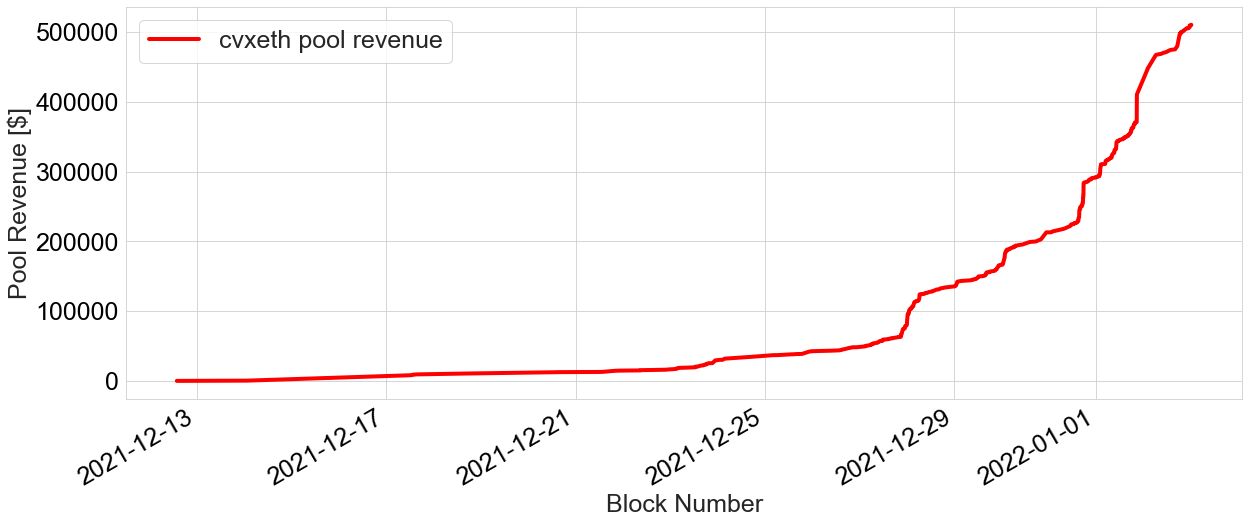

In [17]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_fees['total_claimed_usd']*2).cumsum().plot(
    ax=ax,
    color='red',
    label='cvxeth pool revenue',
    lw=4
)

ax.set_ylabel("Pool Revenue [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);

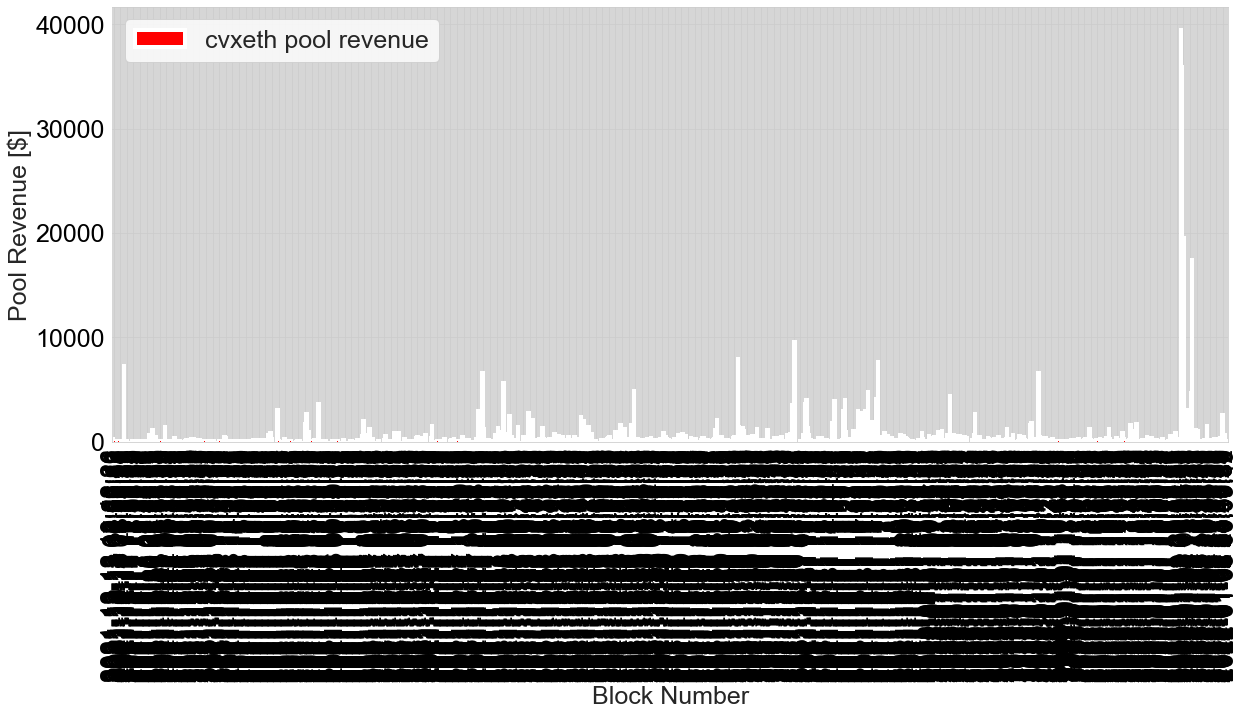

In [18]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_fees['total_claimed_usd']*2).plot(
    ax=ax,
    color='red',
    label='cvxeth pool revenue',
    lw=4,
    kind='bar'
)

ax.set_ylabel("Pool Revenue [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);